# Clustering of Social Groups Using Census Demographic Variables

#### Purpose of this notebook
- 1) Use scikit-learn K-Means to create social groups across Toronto, Vancouver, Montreal

#### Data Sources
- Census Variables: https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/prof/details/download-telecharger/comp/page_dl-tc.cfm?Lang=E
- Census Geographies: https://www12.statcan.gc.ca/census-recensement/2011/geo/bound-limit/bound-limit-2016-eng.cfm

In [1]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import matplotlib.pyplot as plt
os.chdir('C:/Users/Leonardo/OneDrive/Documents/MetroWork/RealEstateData')

In [2]:
# make dataframe with variables of interest
import re
variables = open("CensusData2016/Census/Test2Variables.txt")
var_list = []
for line in variables:
    var_list.append(line)

var_df = pd.DataFrame({'census_variable': var_list})
var_df = var_df.census_variable.str.split(pat = ".", expand=True)[[0,1]]
#var_df = var_df['1'].str.split(pat = "/n", expand=True)[[0,1]]
var_df = var_df[[0,1]]
var_df.columns = ['Member ID: Profile of Dissemination Areas (2247)', 'DIM: Profile of Dissemination Areas (2247)']

In [3]:
# Read Canada Census data by dissemination area
Canada_census_2016 = gpd.read_file('CensusData2016_MA/CanadaWide/CanadaDAs_Census2016_vars.shp')

In [4]:
#function for extracting metropolitan census blocks
def get_metrocensus(canada=None, MAID=[], MANAMES=[], PROVFILTER=[]): 
    '''filters canadian census layer by metropolitan area, and dissolves all polygons. The result is metropolitan boundaries'''
    #create new col to be used with dissolve
    MAREA = canada[canada.CDNAME.isin(MANAMES) & ~canada.PRUID.isin(PROVFILTER) | canada.CMAPUID.isin(MAID)]
    return MAREA

In [6]:
# extract census blocks for all cities
MTMVMOMCMEMM = get_metrocensus(canada=Canada_census_2016, MAID=['59933', '24462'], 
                               MANAMES=['Toronto', 'Hamilton', 'Durham', 'Halton', 'Peel', 'York'], PROVFILTER=['13'])
MTMVMOMCMEMM.CMANAME.unique()

array(['Montréal', 'Toronto', 'Oshawa', None, 'Hamilton', 'Vancouver'],
      dtype=object)

# K-Means Clustering
### Extracting Social Groups from Census Data

### 1: Scale Data and Get rid of Outliers

In [7]:
#prepare dataframe for ML algorithm
df = pd.DataFrame(MTMVMOMCMEMM.iloc[:,23:214])
df = df.replace([np.inf, -np.inf], 0)
#MVDA_Census2016_vars_PCA = MVDA_Census2016_vars_PCA.drop(['index'], axis = 1)
df.head()

,GEO_NAME,6,35,36,37,38,39,40,58,59,...,2238,2239,2240,2241,2242,2243,2244,2245,2246,2247
7636,24520106,1725.0,17.8,64.4,17.8,2.0,42.2,44.3,2.2,415.0,...,0.0,440.0,62.500000,37.500000,27.272727,10.227273,10.227273,10.227273,0.00000,0.000000
7637,24520107,3086.3,17.4,68.0,14.6,0.6,39.4,39.9,2.4,735.0,...,0.0,850.0,65.294118,34.117647,12.941176,21.764706,21.764706,21.764706,0.00000,0.000000
7638,24520108,1564.9,16.3,60.8,22.9,1.8,44.1,47.8,2.1,695.0,...,0.0,705.0,68.794326,31.205674,14.893617,15.602837,13.475177,12.765957,1.41844,2.127660
7639,24520109,2347.5,15.1,65.8,19.2,5.5,42.9,41.7,2.4,620.0,...,0.0,610.0,62.295082,37.704918,22.131148,15.573770,15.573770,15.573770,0.00000,0.000000
8196,24580103,5631.4,16.4,70.9,13.6,0.9,38.9,37.6,2.2,465.0,...,0.0,510.0,47.058824,52.941176,28.431373,25.490196,22.549020,21.568627,0.00000,2.941176


In [37]:
#split into X data and y blocks
X = df.iloc[:,1:]  # all rows, all the features and no labels
y = df.iloc[:, 0]  # all rows, label (census blocks) only

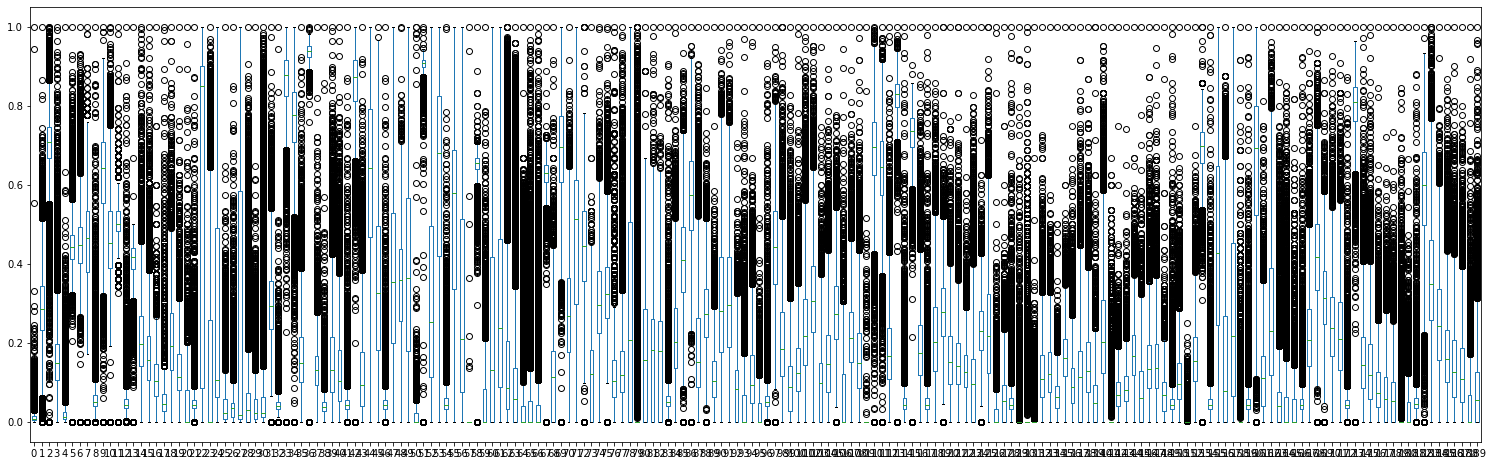

In [9]:
#import libraries, scale the data
from scipy.stats import mstats
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import (KNeighborsClassifier,
                               NeighborhoodComponentsAnalysis)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#scaler = StandardScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
#visualize distribution of variables/outliers
pd.DataFrame(X_scaled).plot.box(figsize=(26,8))

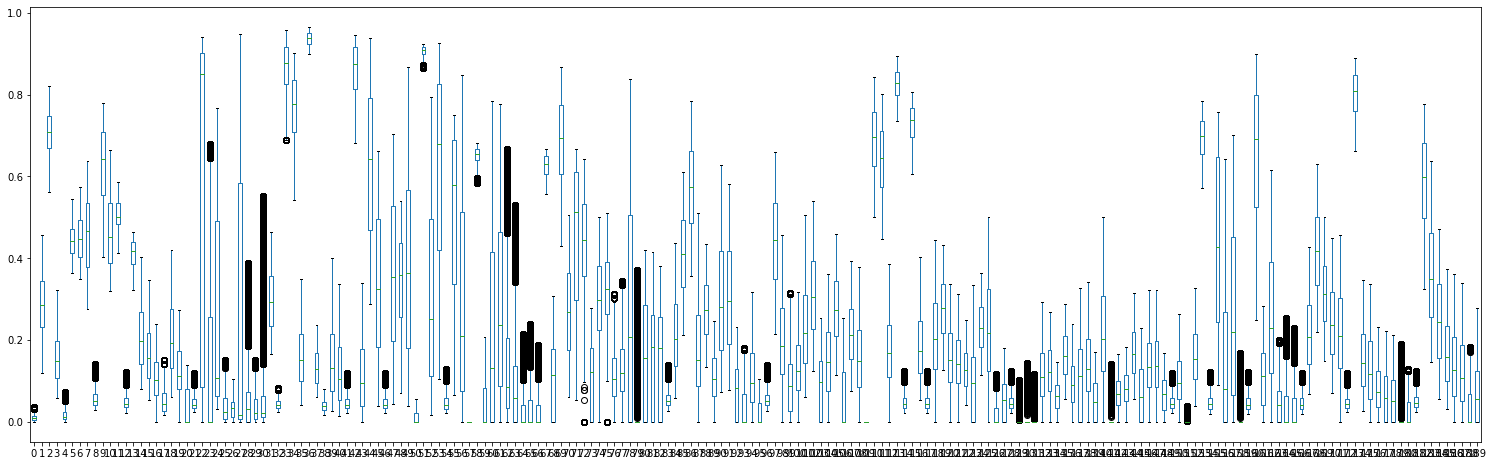

In [10]:
#remove outliers by winsorizing data
X_scaled_wd = mstats.winsorize(X_scaled, inplace = True, axis = 0, limits = [0.05, 0.05])
#visualize data
pd.DataFrame(X_scaled_wd).plot.box(figsize=(26,8))

### 2: Fit K-Means algorithm to our data and find the optimal number of clusters

In [102]:
#clustering data using k means
from sklearn.cluster import KMeans
from sklearn import cluster, mixture
from sklearn.metrics import silhouette_score
kmeans5 = KMeans(n_clusters=5)
k5cls_rnd_20_inits = KMeans(n_clusters=5, init="random", n_init=20,
                              algorithm="full", random_state=11)
k5cls = k5cls_rnd_20_inits.fit(X_scaled_wd)

In [94]:
k5cls_rnd_20_inits_Kplus = KMeans(algorithm='auto', init='k-means++', max_iter=300, 
                                  n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
                                  random_state=None, tol=0.0001)

k5cls_Kplus = k5cls_rnd_20_inits_Kplus.fit(X_scaled_wd)

In [95]:
print(k5cls_rnd_20_inits.inertia_)
print(k5cls_rnd_20_inits_Kplus.inertia_)

29010.32057588184
29010.316162252566


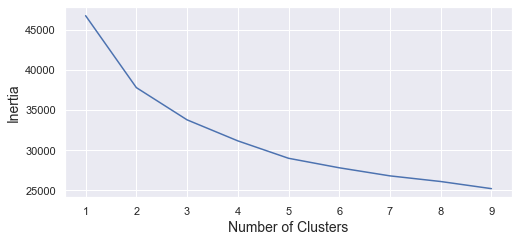

In [119]:
#to chose the right number of clusters we visualize the inertia of the clusters
kmeans_per_k = [KMeans(n_clusters=k, algorithm='auto', init='k-means++', 
                       max_iter=300, n_init=10, n_jobs=None, precompute_distances='auto',
                       random_state=None, tol=0.0001).fit(X_scaled_wd) for k in range(1, 10)]

inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias)
plt.xlabel("Number of Clusters", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
# plt.annotate('Elbow',
#              xy=(5, inertias[3]),
#              xytext=(0.55, 0.55),
#              textcoords='figure fraction',
#              fontsize=16,
#              arrowprops=dict(facecolor='black', shrink=0.1)
#             )
# plt.axis([1, 8.5, 0, 1300])
plt.show()

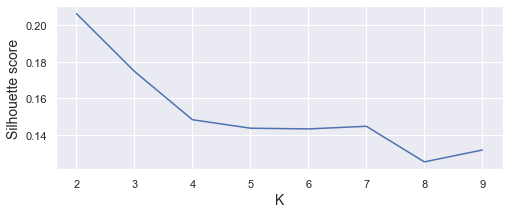

In [120]:
#we visualize the silhouette scores
silhouette_scores = [silhouette_score(X_scaled_wd, model.labels_) for model in kmeans_per_k[1:]]
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores)
plt.xlabel("K", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

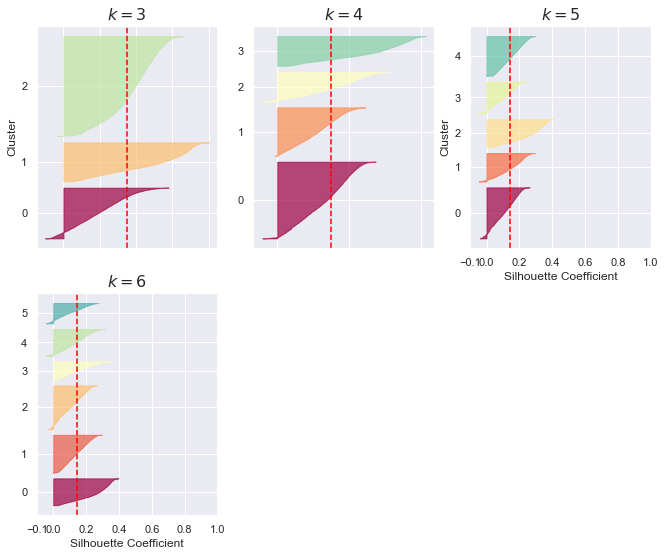

In [121]:
#the silhouette scores can be visualized for each label within each number of clusters
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib

plt.figure(figsize=(11, 9))
# we visualize 4 plots, one for the result of each of k-means with 3, 4, 5, and 6 clusters 
for k in (3, 4, 5, 6):
    plt.subplot(2, 3, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X_scaled_wd, y_pred)

    padding = len(X_scaled_wd) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = matplotlib.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

In [151]:
#THE CHOICE IS 4 CLUSTERS: the silhouette scores are highest, each label is about the average silhouette coefficient, and each cluster is of similar size
k4cls_rnd_10_inits_Kplus = KMeans(algorithm='auto', init='k-means++', max_iter=300, 
                                  n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
                                  random_state=None, tol=0.0001)

k4cls_Kplus = k4cls_rnd_10_inits_Kplus.fit(X_scaled_wd)

In [153]:
#now lets merge back the labels to the initial dataframe
X_std1 = pd.DataFrame(X_scaled_wd)
X_std1.columns = df.iloc[:,1:191].columns
X_std1['GEO_NAME'] = y.values
#X_std1 = pd.concat([X_std1, pd.Series(y)], axis = 1)
X_std1['k4cls'] = k4cls_Kplus.labels_
X_std1.head()

,6,35,36,37,38,39,40,58,59,60,...,2240,2241,2242,2243,2244,2245,2246,2247,GEO_NAME,k4cls
0,0.003577,0.330241,0.668050,0.180894,0.022099,0.460699,0.478919,0.379310,0.045907,0.624223,...,0.572917,0.382979,0.342752,0.114165,0.145903,0.147254,0.000000,0.000000,24520106,1
1,0.006399,0.322820,0.705394,0.148374,0.006630,0.430131,0.431351,0.413793,0.081305,0.643609,...,0.598529,0.348436,0.162639,0.242955,0.310496,0.313371,0.000000,0.000000,24520107,1
2,0.003245,0.302412,0.630705,0.232724,0.019890,0.481441,0.516757,0.362069,0.076881,0.623930,...,0.630615,0.318696,0.187177,0.174171,0.192238,0.183806,0.049272,0.033688,24520108,1
3,0.004868,0.280148,0.682573,0.195122,0.060773,0.468341,0.450811,0.413793,0.068584,0.644907,...,0.571038,0.385072,0.278135,0.173847,0.222176,0.224233,0.000000,0.000000,24520109,1
4,0.011677,0.304267,0.735477,0.138211,0.009945,0.424672,0.406486,0.379310,0.051438,0.532881,...,0.431373,0.540676,0.357313,0.284542,0.321686,0.310548,0.000000,0.046569,24580103,2


In [159]:
#merge back to spatial layer and save data to shapefile
MTMVMOMCMEMM['DAUID'] = MTMVMOMCMEMM['DAUID'].astype('int64')
#Census2016_5Kcls = pd.merge(MTMVMOMCMEMM, X_std1, left_on='DAUID', right_on='GEO_NAME')
Census2016_4Kcls = pd.merge(MTMVMOMCMEMM, X_std1, left_on='DAUID', right_on='GEO_NAME')
#Census2016_5Kcls
Census2016_4Kcls.to_file('CensusData2016_MA/PCA/MTMVMM_DA_Census2016_4Kcls.shp')

C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### 2: Visualize the nature of the clusters

Text(0.5, 1.0, 'Size of K-Means Clusters')

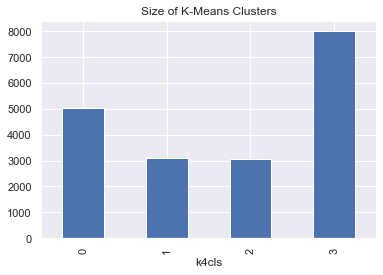

In [160]:
#visualize the size of the clusters
ksizes = X_std1.groupby('k4cls').size()
ksizes.plot(kind = 'bar')
plt.title("Size of K-Means Clusters")

In [132]:
# Calculate the mean by group
k4means = X_std1.groupby('k4cls').mean()
# Show the table transposed (so it's not too wide)
k4means_vars = pd.merge(k5means.T.reset_index(), var_df, left_on='index', right_on='Member ID: Profile of Dissemination Areas (2247)')
k4means_vars.head()

,index,0,1,2,3,4,Member ID: Profile of Dissemination Areas (2247),DIM: Profile of Dissemination Areas (2247)
0,6,0.006221,0.019241,0.005922,0.020562,0.011065,6,Population density per square kilometre\n
1,35,0.294425,0.249073,0.312849,0.286330,0.294766,35,0 to 14 years\n
2,36,0.688701,0.732160,0.692073,0.707946,0.713904,36,15 to 64 years\n
3,37,0.166969,0.150097,0.161860,0.157784,0.152374,37,65 years and over\n
4,38,0.020178,0.021503,0.014477,0.021214,0.017534,38,85 years and over\n


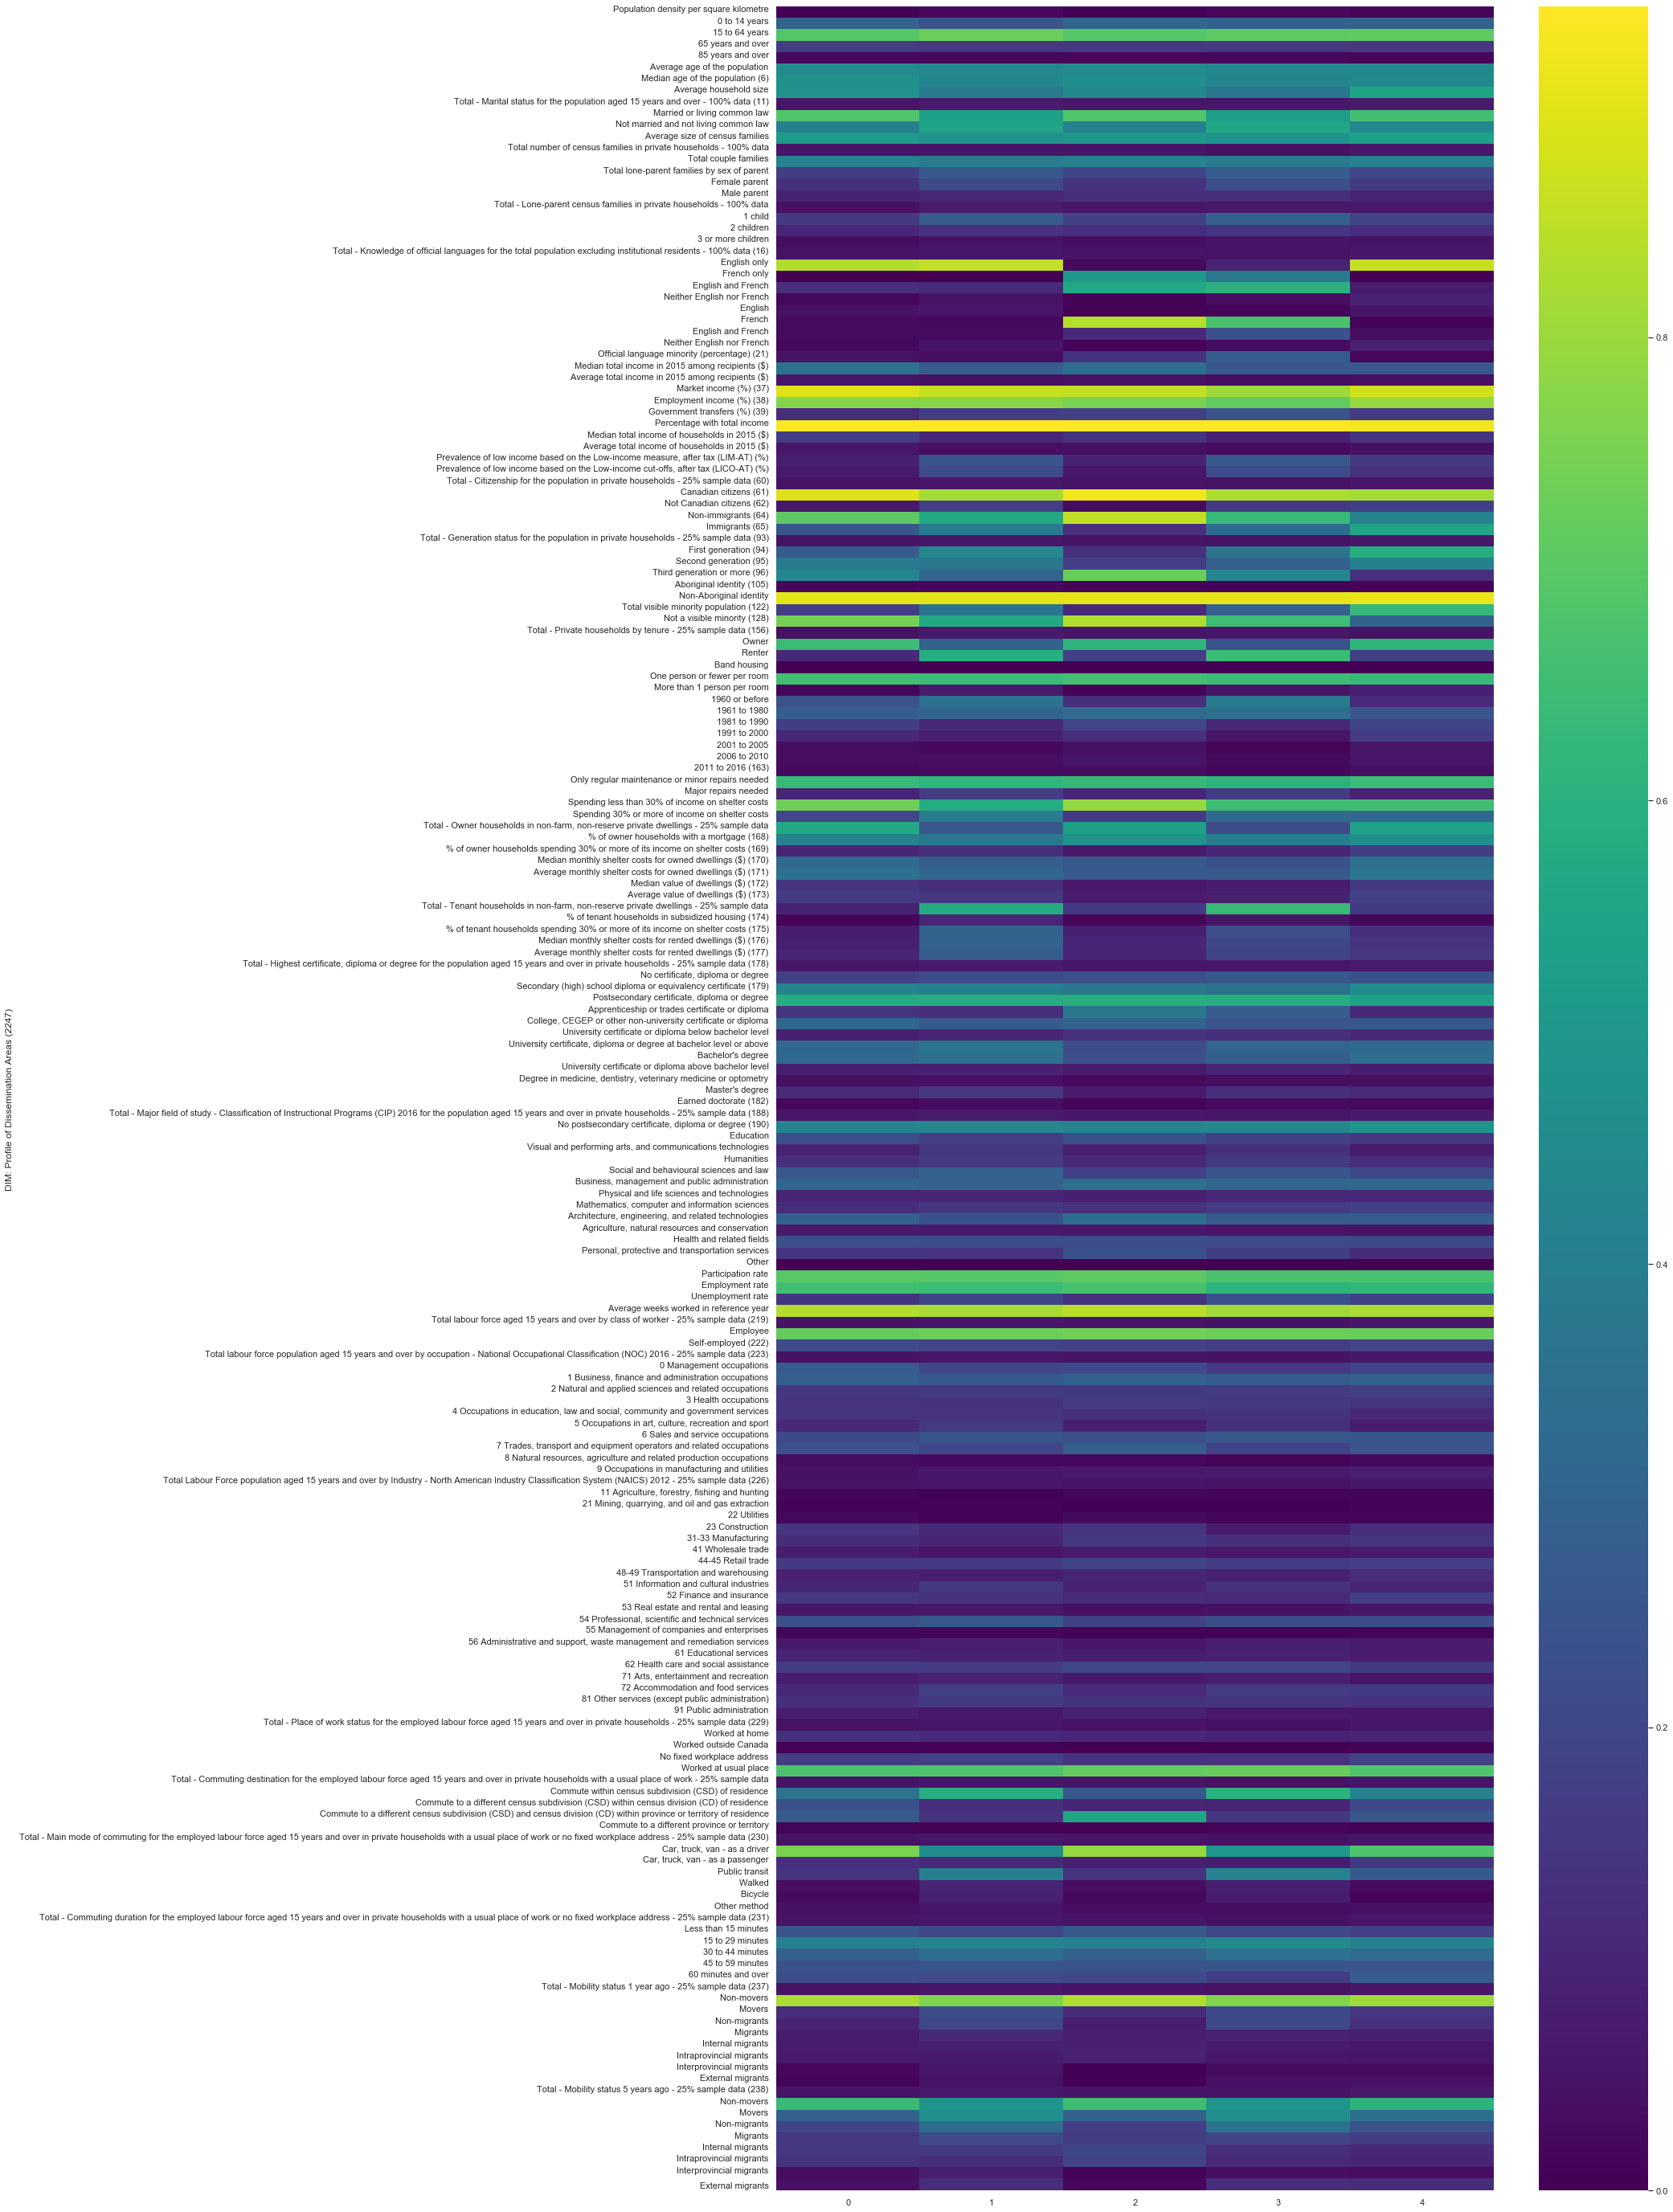

In [133]:
import seaborn as sns; sns.set(color_codes=True)
k4means_vars_ind = k4means_vars.set_index('DIM: Profile of Dissemination Areas (2247)').drop(columns=["index","Member ID: Profile of Dissemination Areas (2247)"], axis=1)
k4means_vars_ind
fig, ax = plt.subplots(figsize=(20,50))
g = sns.heatmap(k5means_vars_ind, annot=False, cmap  = 'viridis')